In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

nltk.download('punkt')
# Load the dataset
df = pd.read_csv('train.csv')

# Dictionary linking metaphorID to specific words
metaphor_words = {
    0: 'road',
    1: 'candle',
    2: 'light',
    3: 'spice',
    4: 'ride',
    5: 'train',
    6: 'boat'
}

# Function to clean and extract context around the metaphor candidate word
def extract_context(text, metaphor_id, window_size=5):
    target_word = metaphor_words[metaphor_id]
    words = word_tokenize(text)
    if target_word in words:
        target_index = words.index(target_word)
        start = max(0, target_index - window_size)
        end = min(len(words), target_index + window_size + 1)
        return ' '.join(words[start:end])
    else:
        return ''

# Apply the cleaning and context extraction function
df['context'] = df.apply(lambda row: extract_context(row['text'], row['metaphorID']), axis=1)

# Remove rows with empty context
df = df[df['context'] != '']

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['context']).toarray()
y = df['label_boolean'].values

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB()
}

# Dictionary to store average accuracies
average_accuracies = {}

# Perform cross-validation and compare models
k = 5  # Number of folds
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy')
    average_accuracy = cv_scores.mean()
    average_accuracies[name] = average_accuracy
    print(f"{name} - Cross-Validation Scores for {k} folds: {cv_scores}")
    print(f"{name} - Average Accuracy: {average_accuracy}")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Logistic Regression - Cross-Validation Scores for 5 folds: [0.84615385 0.83516484 0.83516484 0.83150183 0.83455882]
Logistic Regression - Average Accuracy: 0.836508834302952
Random Forest - Cross-Validation Scores for 5 folds: [0.86813187 0.84615385 0.87912088 0.85347985 0.85661765]
Random Forest - Average Accuracy: 0.8607008187890541
SVM - Cross-Validation Scores for 5 folds: [0.85347985 0.84249084 0.84981685 0.84249084 0.83823529]
SVM - Average Accuracy: 0.8453027364792071
Naive Bayes - Cross-Validation Scores for 5 folds: [0.83516484 0.83516484 0.82417582 0.83150183 0.83088235]
Naive Bayes - Average Accuracy: 0.8313779357897004


In [5]:

# PyTorch Dataset
class MetaphorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = MetaphorDataset(X_train, y_train)
test_dataset = MetaphorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Batch size set to 1 for stochastic gradient descent
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Neural Network Model
class MetaphorNN(nn.Module):
    def __init__(self, input_size):
        super(MetaphorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model, Loss, Optimizer
model = MetaphorNN(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training Loop
for epoch in range(10):  # number of epochs
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

accuracy_nn = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy_nn}")


<ipython-input-5-248a64bd33bd>:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 1, Loss: 0.17913083732128143
Epoch 2, Loss: 1.8064749240875244
Epoch 3, Loss: 1.8230869770050049
Epoch 4, Loss: 0.19372554123401642
Epoch 5, Loss: 0.2662990093231201
Epoch 6, Loss: 0.25081369280815125
Epoch 7, Loss: 0.35161635279655457
Epoch 8, Loss: 0.6361056566238403
Epoch 9, Loss: 0.004015123005956411
Epoch 10, Loss: 0.0050664134323596954
Accuracy: 0.8654970760233918


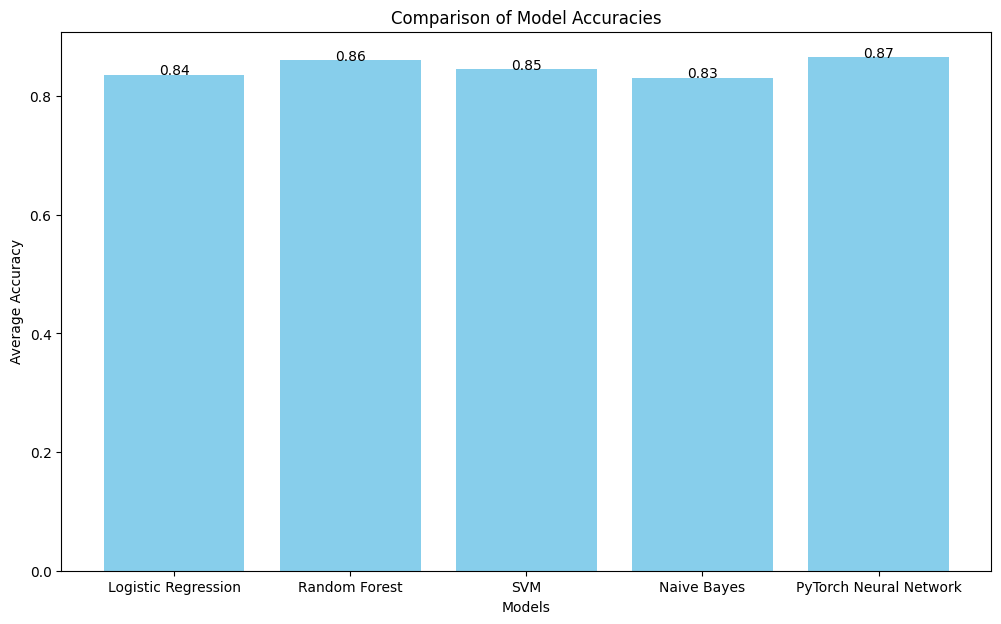

In [6]:
# Add the PyTorch model accuracy to the dictionary
average_accuracies['PyTorch Neural Network'] = accuracy_nn

import matplotlib.pyplot as plt

# Update model names and accuracies
model_names = list(average_accuracies.keys())
accuracies = list(average_accuracies.values())

# Creating the bar chart
plt.figure(figsize=(12, 7))  # Adjusted for additional model
plt.bar(model_names, accuracies, color='skyblue')

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Average Accuracy')

# Adding the accuracy values on top of the bars
for i in range(len(model_names)):
    plt.text(i, accuracies[i], round(accuracies[i], 2), ha='center')

# Display the plot
plt.show()
